In [35]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil


What It Does:
Iterates through every file in the dataset.

Attempts to open each image file.

If an image is corrupted or unreadable, it is deleted.

Logs the number of removed files.

In [36]:
def is_valid_image(file_path):
    try:
        img = Image.open('/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/Dataset')
        img.verify() #should raise an exception is corrupted
        return True
    except Exception:
        return False

def clean_image_dataset(root_folder):
    invalid_files = []

    for class_folder in os.listdir(root_folder):
        class_path = os.path.join(root_folder, class_folder)

        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            file_path = os.path.join(class_path, img_file)

            if not is_valid_image(file_path):
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)
                invalid_files.append(file_path)

    print(f"\nTotal invalid images removed: {len(invalid_files)}")

In [37]:
clean_image_dataset('/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/Dataset')


Total invalid images removed: 0


What It Does
Resizes all images to a standard size (default: 224x224 pixels).

Normalizes pixel values to the range [0, 1] (for ML compatibility).

Saves processed images in a new directory.

In [38]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def preprocess_and_save_images(input_dir, output_dir, size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)

    for entry in os.listdir(input_dir):
        entry_path = os.path.join(input_dir, entry)

        if os.path.isfile(entry_path):
            # Single image, not a folder
            try:
                img = cv2.imread(entry_path)
                img = cv2.resize(img, size)
                img = img / 255.0  # Normalize
                output_path = os.path.join(output_dir, entry)
                cv2.imwrite(output_path, (img * 255).astype(np.uint8))
            except Exception as e:
                print(f"Skipping {entry_path}: {e}")

        elif os.path.isdir(entry_path):
            # If it's a folder, process all images inside
            output_class_path = os.path.join(output_dir, entry)
            os.makedirs(output_class_path, exist_ok=True)

            for img_file in tqdm(os.listdir(entry_path), desc=f"Processing {entry}"):
                img_path = os.path.join(entry_path, img_file)
                output_path = os.path.join(output_class_path, img_file)

                try:
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, size)
                    img = img / 255.0  # Normalize
                    cv2.imwrite(output_path, (img * 255).astype(np.uint8))
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")


In [39]:
preprocess_and_save_images('/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/Dataset', '/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/SavedImagesAI')

To improve the diversity and robustness of our American Sign Language (ASL) image dataset, we applied a series of image augmentation techniques. These augmentations help our YOLOv9 model generalize better by simulating various real-world scenarios. Below are the key steps:

Augmentation Techniques Used:
Random Rotation: Each image is randomly rotated between -30 to +30 degrees to simulate different hand orientations.

Horizontal Flip: Images are randomly flipped to increase variability in hand positioning.

Scaling: We applied random zoom-in and zoom-out operations to simulate varying distances from the camera.

Padding or Cropping: After scaling, images are either padded or cropped to maintain consistent dimensions.

Resizing: Final images are resized to 640x640 pixels to match YOLOv9’s expected input size.

Folder Structure
Input Folder: Contains the original class-wise folders of resized ASL images (e.g., A, B, C...).

Output Folder: Stores both the original and augmented versions of each image, with filenames like A_01_original.jpg, A_01_aug1.jpg, etc.

Benefits
Increases dataset size without requiring more labeled data.

Makes the model more resilient to real-world conditions like lighting, orientation, and scale.

Reduces overfitting by introducing controlled randomness.

In [47]:
import cv2
import numpy as np
import os

def augment_image(image):
    # Random rotation
    angle = np.random.randint(-30, 30)
    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    
    # Random horizontal flip
    if np.random.rand() > 0.5:
        rotated = cv2.flip(rotated, 1)
    
    # Random scaling
    scale = np.random.uniform(0.8, 1.2)
    resized = cv2.resize(rotated, None, fx=scale, fy=scale)

    # Cropping or padding to original size
    if scale < 1.0:
        delta_w = image.shape[1] - resized.shape[1]
        delta_h = image.shape[0] - resized.shape[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        augmented = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        augmented = cv2.resize(resized, (image.shape[1], image.shape[0]))
    
    final_img = cv2.resize(augmented, (640, 640))
    return final_img

# Paths
words_dir = '/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/Dataset'
output_base_path = '/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/augmented_dataset/images'

# Ensure output directory exists
os.makedirs(output_base_path, exist_ok=True)

# Process each image directly
for idx, image_file in enumerate(os.listdir(words_dir)):
    image_path = os.path.join(words_dir, image_file)
    
    if not os.path.isfile(image_path) or not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    
    print(f'Processing: {image_path}')
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image {image_path}")
        continue
    
    # Save the original
    base_name = os.path.splitext(image_file)[0]
    original_save_path = os.path.join(output_base_path, f"{base_name}_original.jpg")
    cv2.imwrite(original_save_path, cv2.resize(image, (640, 640)))
    
    # Generate and save 3 augmentations
    for i in range(3):
        aug_img = augment_image(image)
        aug_img_name = os.path.join(output_base_path, f"{base_name}_aug{i}.jpg")
        cv2.imwrite(aug_img_name, aug_img)
        print(f'Saved: {aug_img_name}')

print("Image augmentation complete.")


Processing: /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/Dataset/G26_jpg.rf.887b7eedb4f32e7f622619094dc8a0b2.jpg
Saved: /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/augmented_dataset/images/G26_jpg.rf.887b7eedb4f32e7f622619094dc8a0b2_aug0.jpg
Saved: /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/augmented_dataset/images/G26_jpg.rf.887b7eedb4f32e7f622619094dc8a0b2_aug1.jpg
Saved: /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/augmented_dataset/images/G26_jpg.rf.887b7eedb4f32e7f622619094dc8a0b2_aug2.jpg
Processing: /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/Dataset/S29_jpg.rf.b661aab69dbd76c5252db309fcd420c3.jpg
Saved: /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/augmented_dataset/images/S29_jpg.rf.b661aab69dbd76c5252db309fcd420c3_aug0.jpg
Saved: /Users/jonathanodonkor/De

Dataset Splitting for Training, Validation, and Testing
To ensure our machine learning model is properly trained and evaluated, we split the dataset into three distinct sets: training, validation, and testing. The function below automates this process.

What the Code Does
Reads Image Classes: Iterates over each class folder (e.g., A, B, C…) in the input directory.

Splits Images:

Test Set (20%): Used for final evaluation of model performance.

Validation Set (10%): Used to tune hyperparameters and prevent overfitting.

Training Set (70%): Used to train the model.

Creates Folders: Automatically generates subdirectories for train, val, and test within the output base folder.

Copies Files: Places each image into its corresponding split directory, preserving class subfolders.

In [42]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(input_dir, output_base, test_size=0.2, val_size=0.1):
    # List all images (assuming all are directly inside input_dir)
    images = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

    # Split into train, test, val
    train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=val_size, random_state=42)

    for split, img_list in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_dir = os.path.join(output_base, split)
        os.makedirs(split_dir, exist_ok=True)

        for img_name in img_list:
            src = os.path.join(input_dir, img_name)
            dst = os.path.join(split_dir, img_name)
            shutil.copy2(src, dst)


In [43]:
split_dataset('/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/Dataset','/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/splitDataset')

We are using MediaPipe Hands to detect hands in each image.

Generate a bounding box around detected hands.

Save the annotations in YOLO format (.txt files).

Place the annotated images and labels in a structure ready for splitting.

In [49]:
import os
import cv2
import mediapipe as mp

# MediaPipe hands model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

# Define paths
input_dir = '/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/augmented_dataset/images'
output_images_dir = '/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/augmented_dataset/imagesLabels'
output_labels_dir = '/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/augmented_dataset/labels'

# Create output folders
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

def get_yolo_bbox(image_width, image_height, x_min, y_min, x_max, y_max):
    # Convert to YOLO format: center_x, center_y, width, height (normalized)
    x_center = (x_min + x_max) / 2 / image_width
    y_center = (y_min + y_max) / 2 / image_height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height
    return x_center, y_center, width, height

# Iterate over input images
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"⚠️ Failed to load {image_path}")
            continue

        h, w, _ = image.shape
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.multi_hand_landmarks:
            label_file = os.path.splitext(filename)[0] + ".txt"
            label_path = os.path.join(output_labels_dir, label_file)

            with open(label_path, 'w') as f:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Get bounding box around the hand
                    xs = [lm.x * w for lm in hand_landmarks.landmark]
                    ys = [lm.y * h for lm in hand_landmarks.landmark]
                    x_min, x_max = int(min(xs)), int(max(xs))
                    y_min, y_max = int(min(ys)), int(max(ys))

                    # Draw the bounding box
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                    # Save YOLO bbox
                    x_center, y_center, box_width, box_height = get_yolo_bbox(w, h, x_min, y_min, x_max, y_max)
                    f.write(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")
        else:
            print(f"❌ No hand detected in {filename}, skipping annotation...")

        # Save the annotated image
        cv2.imwrite(os.path.join(output_images_dir, filename), image)

print("Annotation complete!")


I0000 00:00:1745729796.340606 3694648 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1745729796.366566 5116496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745729796.376379 5116496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


❌ No hand detected in G26_jpg.rf.887b7eedb4f32e7f622619094dc8a0b2.jpg, skipping annotation...
❌ No hand detected in S29_jpg.rf.b661aab69dbd76c5252db309fcd420c3.jpg, skipping annotation...
❌ No hand detected in I12_jpg.rf.4c8263600f0c310868b55e13ee2bb2f8_aug1.jpg, skipping annotation...
❌ No hand detected in U12_jpg.rf.caab030d17c3d09fd2aa7a6f251fdf58_aug1.jpg, skipping annotation...
❌ No hand detected in P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9_original.jpg, skipping annotation...
❌ No hand detected in T3_jpg.rf.ea6e58654e6f68de2e0b7b12ac1d9dec_aug0.jpg, skipping annotation...
❌ No hand detected in F24_jpg.rf.b439c3fcb01186c832c07b105383ea93.jpg, skipping annotation...
❌ No hand detected in Q3_jpg.rf.27f364cf93f8a66e0f5b509cd1dbb1ae.jpg, skipping annotation...
❌ No hand detected in K25_jpg.rf.b7430b01444b7b3dda9f5b5eff5ab5c6_aug2.jpg, skipping annotation...
❌ No hand detected in O14_jpg.rf.df7a8fabf8dfbcc45a9a4fee5636225f_aug2.jpg, skipping annotation...
❌ No hand detected in W14_jp

A pretrained model for image processing is helpful for sign language data because it already understands low-level visual features like shapes, edges, and textures — this allows us to transfer that knowledge to our task with less training data and better performance.

YOLO is the ideal choice for this project because:

1. Real-Time Object Detection
YOLO is designed for real-time applications — it can detect hand gestures from a webcam stream at high speed.

Perfect for live sign language interpretation where latency must be minimal.

2. Single-Pass Inference
Unlike other models that scan an image in parts, YOLO looks at the entire image once and predicts bounding boxes and classes all at once.

This improves speed without sacrificing too much accuracy.

3. Detects Multiple Gestures at Once
YOLO can handle multiple hands in the frame and detect multiple sign gestures simultaneously.

Useful in cases where both hands or multiple people are signing.

4. Transfer Learning with YOLOv9
We can fine-tune YOLOv9 with our custom sign language dataset.

YOLOv9 comes with optimizations for small objects and dense scenes, which are common in hand gesture data.

In [ ]:
#downloading yolo
import os
from ultralytics import YOLO

def download_yolov9():
    # Specify the base directory
    base_dir = os.path.expanduser("~/Desktop/ES/nnn")

    
    # Create a directory for YOLOv9 if it doesn't exist
    yolov9_dir = os.path.join(base_dir, "yolov9")
    os.makedirs(yolov9_dir, exist_ok=True)
    
    # Change to the YOLOv9 directory
    os.chdir(yolov9_dir)
    
    # Download YOLOv9n model
    model = YOLO("yolov9s.pt")
    
    print(f"YOLOv model downloaded and saved in {yolov9_dir}")
    
 
    return model

# Run the download function
yolov9_model = download_yolov9()

Loads the YOLOv9s (small variant) model which is already pretrained on the COCO dataset.

This model understands general image features like shapes, edges, and positions.

We fine-tune it on your ASL dataset to specialize it in detecting hand gestures.

Result:
Once training finishes, the model will be:

Specialized in detecting ASL hand signs.

Exported to a weights file like best.pt inside:
asl_yolo9_training/yolov9n_asl/

In [1]:
from ultralytics import YOLO

# Load pretrained YOLOv9n model
model = YOLO('/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/ES/nnn/yolov9/yolov9s.pt')

# Train on your ASL dataset
results = model.train(
    data="/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/data.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    project="asl_yolo9_training",
    name="yolov9n_asl",
    pretrained=True
)


Ultralytics 8.3.115 🚀 Python-3.12.7 torch-2.7.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/ES/nnn/yolov9/yolov9s.pt, data=/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=asl_yolo9_training, name=yolov9n_asl2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffe

train: Scanning /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/train/labels.cache... 1512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1512/1512 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 8.9±1.7 MB/s, size: 16.8 KB)



/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/valid/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to asl_yolo9_training/yolov9n_asl2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to asl_yolo9_training/yolov9n_asl2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G     0.8484      4.759       1.49          8        640: 100%|██████████| 95/95 [57:01<00:00, 36.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [02:30<00:00, 30.06s/it]

                   all        144        144      0.397      0.464      0.439      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.6145      2.301      1.161          8        640: 100%|██████████| 95/95 [50:03<00:00, 31.62s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:29<00:00, 17.93s/it]

                   all        144        144      0.535      0.686      0.702      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.6186      1.473      1.149          8        640: 100%|██████████| 95/95 [37:37<00:00, 23.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.11s/it]

                   all        144        144      0.682      0.709      0.816      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.6067      1.127       1.13          8        640: 100%|██████████| 95/95 [35:43<00:00, 22.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.69s/it]

                   all        144        144       0.77       0.83      0.895      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      0.567     0.8297      1.092          8        640: 100%|██████████| 95/95 [3:08:52<00:00, 119.29s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:24<00:00, 16.89s/it]

                   all        144        144      0.802      0.818       0.86      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.5387      0.708      1.065          8        640: 100%|██████████| 95/95 [54:06<00:00, 34.18s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:24<00:00, 16.89s/it]

                   all        144        144      0.819      0.873      0.914      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.5076      0.564       1.04          8        640: 100%|██████████| 95/95 [49:08<00:00, 31.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:24<00:00, 16.95s/it]

                   all        144        144      0.842      0.801      0.903      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.5029     0.4701      1.031          8        640: 100%|██████████| 95/95 [48:24<00:00, 30.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:25<00:00, 17.13s/it]

                   all        144        144      0.872      0.873      0.949      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.4766     0.4022      1.013          8        640: 100%|██████████| 95/95 [43:29<00:00, 27.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:15<00:00, 15.11s/it]

                   all        144        144      0.924      0.873       0.95      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.4575     0.3462     0.9877          8        640: 100%|██████████| 95/95 [43:51<00:00, 27.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.98s/it]

                   all        144        144      0.938      0.869      0.955      0.777



10 epochs completed in 10.378 hours.
Optimizer stripped from asl_yolo9_training/yolov9n_asl2/weights/last.pt, 15.2MB
Optimizer stripped from asl_yolo9_training/yolov9n_asl2/weights/best.pt, 15.2MB

Validating asl_yolo9_training/yolov9n_asl2/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.12.7 torch-2.7.0 CPU (Apple M1)
YOLOv9s summary (fused): 197 layers, 7,177,150 parameters, 0 gradients, 26.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 12.00s/it]


                   all        144        144      0.925      0.873       0.95      0.782
                     A          5          5      0.929        0.8       0.92      0.806
                     B          9          9          1      0.517      0.973      0.864
                     C          3          3      0.959          1      0.995      0.796
                     D          6          6      0.839          1      0.948      0.798
                     E          4          4      0.955          1      0.995      0.822
                     F          8          8      0.972          1      0.995      0.829
                     G          5          5          1      0.894      0.995      0.826
                     H          9          9      0.974          1      0.995      0.746
                     I          2          2      0.908        0.5      0.566      0.503
                     J          8          8      0.981          1      0.995      0.675
                     

This script uses OpenCV to access the webcam and runs real-time inference using a custom-trained YOLOv9 model to detect American Sign Language (ASL) gestures. Detected gestures are visualized live with bounding boxes and labels on each video frame.


In [50]:
import cv2
import time
from ultralytics import YOLO

# Load your trained model
model = YOLO('/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/asl_yolo9_training/yolov9n_asl2/weights/best.pt')

# Initialize webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Failed to open webcam.")
else:
    print("✅ Webcam initialized!")
    time.sleep(2)  # Allow camera to warm up

    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Failed to read frame.")
            break

        # Run YOLOv9 inference
        results = model(frame, imgsz=640, conf=0.1)[0]  # Lower conf if needed

        # Visualize detections on the frame
        annotated_frame = results.plot()

        # Show result
        cv2.imshow('ASL Detection', annotated_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


2025-04-27 05:01:23.066 python[8950:3694648] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


✅ Webcam initialized!

0: 384x640 (no detections), 135.5ms
Speed: 18.1ms preprocess, 135.5ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 119.9ms
Speed: 2.6ms preprocess, 119.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 113.7ms
Speed: 1.9ms preprocess, 113.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 101.1ms
Speed: 1.6ms preprocess, 101.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 103.8ms
Speed: 1.6ms preprocess, 103.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 98.3ms
Speed: 1.7ms preprocess, 98.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


2025-04-27 05:01:42.784 python[8950:3694648] +[IMKClient subclass]: chose IMKClient_Legacy
2025-04-27 05:01:42.785 python[8950:3694648] +[IMKInputSession subclass]: chose IMKInputSession_Legacy



0: 384x640 (no detections), 109.8ms
Speed: 2.2ms preprocess, 109.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 107.2ms
Speed: 1.5ms preprocess, 107.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 96.2ms
Speed: 2.2ms preprocess, 96.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 94.2ms
Speed: 1.6ms preprocess, 94.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 97.6ms
Speed: 1.5ms preprocess, 97.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.5ms
Speed: 1.4ms preprocess, 92.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 108.4ms
Speed: 1.5ms preprocess, 108.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 100.5ms
Speed: 1.6ms preprocess, 1

KeyboardInterrupt: 

In [ ]:
# Validate the trained model
from ultralytics import YOLO

# Load model (can be a pretrained one or your own best.pt)
model = YOLO('/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/asl_yolo9_training/yolov9n_asl2/weights/best.pt')

# Run hyperparameter evolution
model.tune(
    data="/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/data.yaml",
    epochs=2,               
    iterations=20, 
    optimizer='AdamW',      
    batch=16,               
    imgsz=640,            
    project="asl_yolo9_tuning",
    name="yolov9n_asl_hpt"
)


Tuner: Initialized Tuner instance with 'tune_dir=asl_yolo9_tuning/yolov9n_asl_hpt2'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/20 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
New https://pypi.org/project/ultralytics/8.3.116 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.115 🚀 Python-3.12.7 torch-2.7.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/asl_yolo9_training/yolov9n_asl2/weights/best.pt, data=/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/In

train: Scanning /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/train/labels.cache... 1512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1512/1512 [00:00<?, ?it/s]
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/valid/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 47.9±35.0 MB/s, size: 16.8 KB)
Plotting labels to asl_yolo9_tuning/train2/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to asl_yolo9_tuning/train2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G      1.443      2.929      1.963          8        640: 100%|██████████| 95/95 [1:06:16<00:00, 41.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:34<00:00, 18.99s/it]


                   all        144        144   0.000282      0.106   0.000409   9.51e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G       1.59      3.105      2.123          8        640: 100%|██████████| 95/95 [1:04:21<00:00, 40.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:32<00:00, 18.50s/it]


                   all        144        144      0.197     0.0922     0.0079    0.00499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G       1.43      2.879      1.967          8        640: 100%|██████████| 95/95 [53:18<00:00, 33.67s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:26<00:00, 17.28s/it]


                   all        144        144     0.0026     0.0595    0.00264    0.00102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.299      2.525      1.816          8        640: 100%|██████████| 95/95 [49:06<00:00, 31.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:26<00:00, 17.30s/it]


                   all        144        144      0.315       0.39      0.173      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.165      2.379      1.677          8        640: 100%|██████████| 95/95 [50:11<00:00, 31.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:25<00:00, 17.01s/it]


                   all        144        144      0.319      0.537      0.329      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.037      2.064      1.534          8        640: 100%|██████████| 95/95 [50:09<00:00, 31.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:23<00:00, 16.74s/it]


                   all        144        144      0.287      0.549      0.385      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.9716      1.844      1.469          8        640: 100%|██████████| 95/95 [50:44<00:00, 32.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:23<00:00, 16.74s/it]


                   all        144        144       0.42      0.591      0.515      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.8816      1.679      1.386          8        640: 100%|██████████| 95/95 [51:17<00:00, 32.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:35<00:00, 19.16s/it]


                   all        144        144      0.595      0.538      0.619      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      0.816      1.505      1.309          8        640: 100%|██████████| 95/95 [51:00<00:00, 32.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:26<00:00, 17.24s/it]


                   all        144        144      0.463      0.634      0.655      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.7584      1.419      1.242          8        640: 100%|██████████| 95/95 [52:21<00:00, 33.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:22<00:00, 16.49s/it]


                   all        144        144      0.596      0.589      0.693      0.554

10 epochs completed in 9.228 hours.
Optimizer stripped from asl_yolo9_tuning/train2/weights/last.pt, 15.2MB
Optimizer stripped from asl_yolo9_tuning/train2/weights/best.pt, 15.2MB

Validating asl_yolo9_tuning/train2/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.12.7 torch-2.7.0 CPU (Apple M1)
YOLOv9s summary (fused): 197 layers, 7,177,150 parameters, 0 gradients, 26.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:23<00:00, 16.69s/it]


                   all        144        144      0.596      0.589      0.693      0.554
                     A          5          5      0.549        0.6      0.678      0.557
                     B          9          9      0.827      0.556       0.79      0.658
                     C          3          3      0.716      0.667      0.806      0.679
                     D          6          6      0.775          1      0.924      0.799
                     E          4          4          1      0.488      0.741      0.623
                     F          8          8      0.733          1      0.982      0.805
                     G          5          5      0.572        0.6      0.661      0.499
                     H          9          9          1      0.439      0.955      0.706
                     I          2          2     0.0953        0.5      0.112      0.101
                     J          8          8          1      0.307      0.644      0.265
                     

train: Scanning /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/train/labels.cache... 1512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1512/1512 [00:00<?, ?it/s]
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/valid/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 68.5±20.6 MB/s, size: 16.8 KB)
Plotting labels to asl_yolo9_tuning/train3/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.91655) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.00042), 227 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to asl_yolo9_tuning/train3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G       1.41      3.062      1.921         16        640:  56%|█████▌    | 53/95 [24:30<17:40, 25.25s/it]/opt/anaconda3/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


KeyboardInterrupt: 

In [55]:
results = model.predict(source='/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images', save=True)



image 1/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images/A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg: 640x640 1 A, 221.2ms
image 2/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images/B14_jpg.rf.ed5ba6d44f55ab03e62d2baeac4aa1aa.jpg: 640x640 1 B, 163.0ms
image 3/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images/B15_jpg.rf.0f0628552139144fc67c453e1f1b7b15.jpg: 640x640 1 B, 165.8ms
image 4/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images/B19_jpg.rf.69527cc1f34d694cc04e55db80ed9b1a.jpg: 640x640 1 B, 159.9ms
image 5/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters


image 1/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images/A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg: 640x640 1 A, 183.7ms
image 2/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images/B14_jpg.rf.ed5ba6d44f55ab03e62d2baeac4aa1aa.jpg: 640x640 1 B, 162.4ms
image 3/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images/B15_jpg.rf.0f0628552139144fc67c453e1f1b7b15.jpg: 640x640 1 B, 161.7ms
image 4/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images/B19_jpg.rf.69527cc1f34d694cc04e55db80ed9b1a.jpg: 640x640 1 B, 166.9ms
image 5/72 /Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters

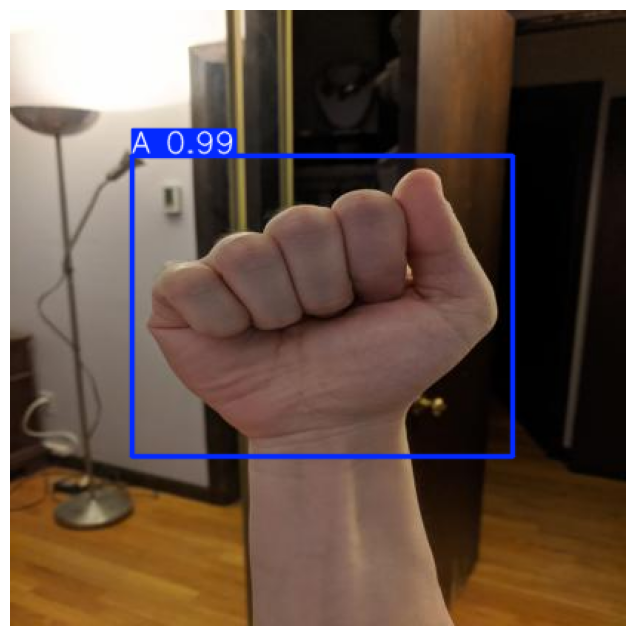

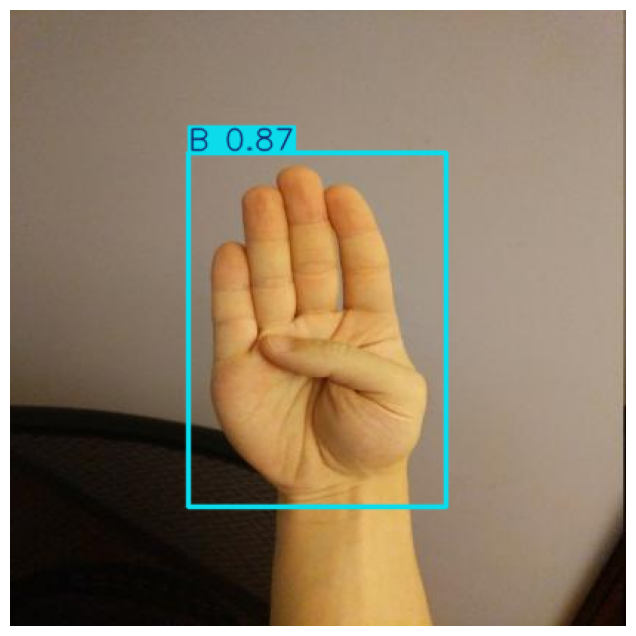

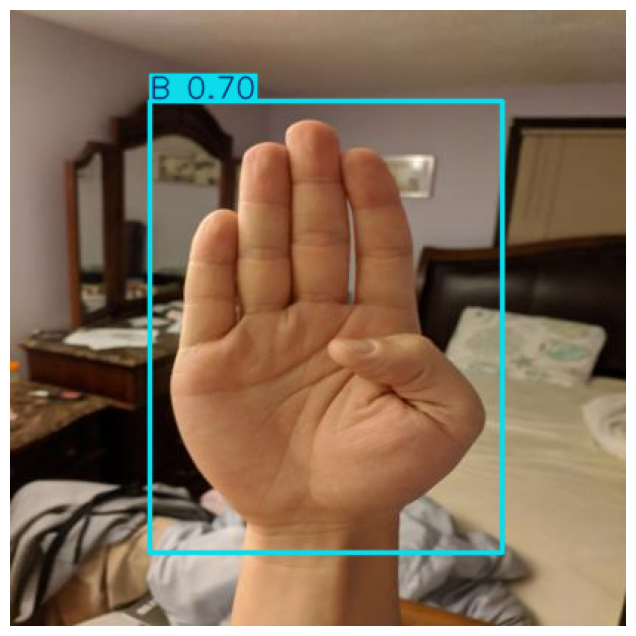

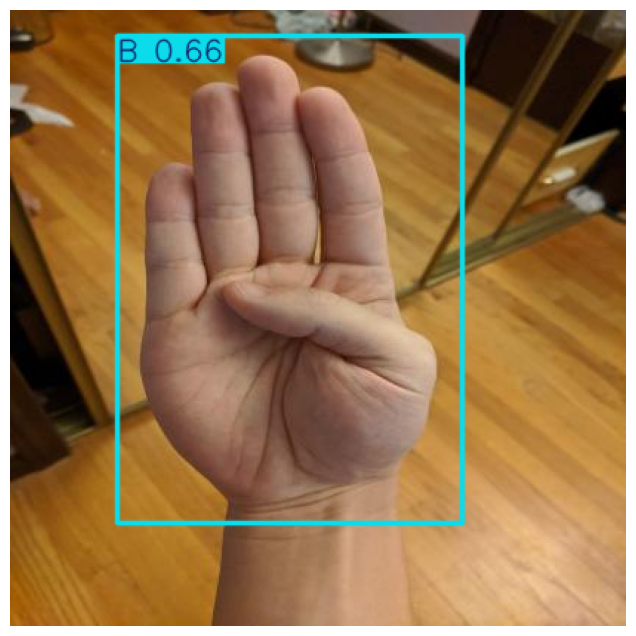

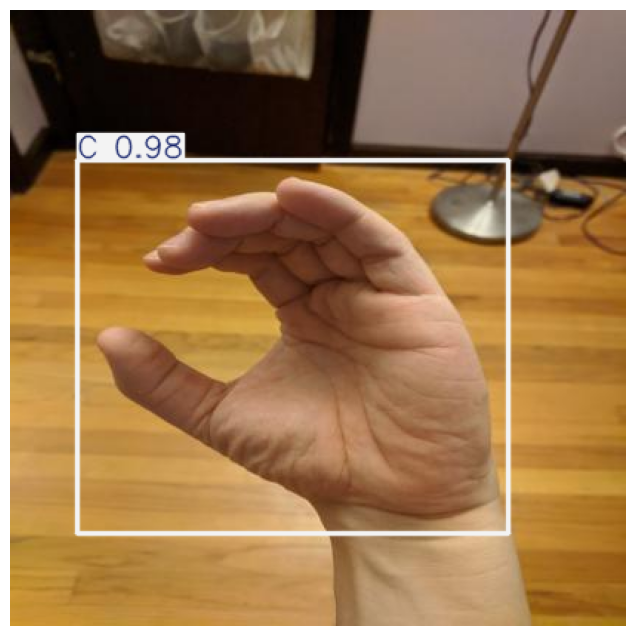

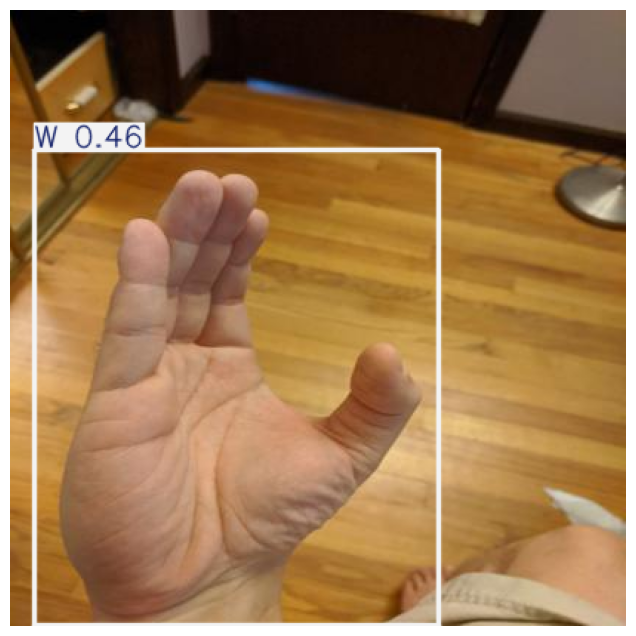

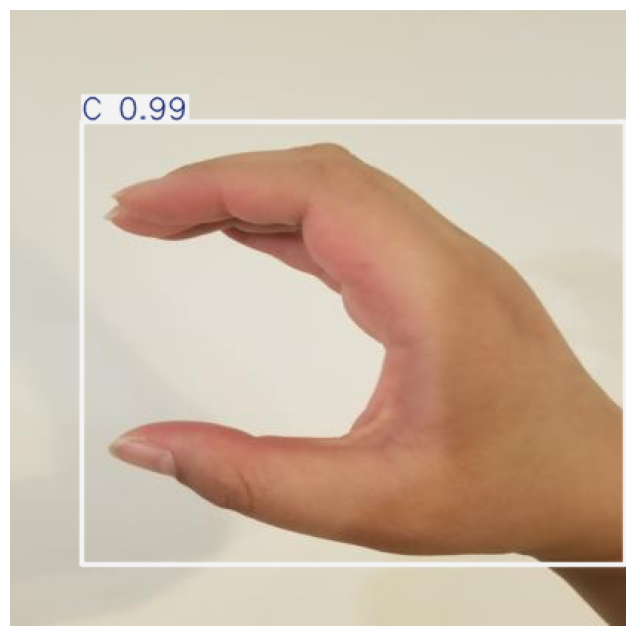

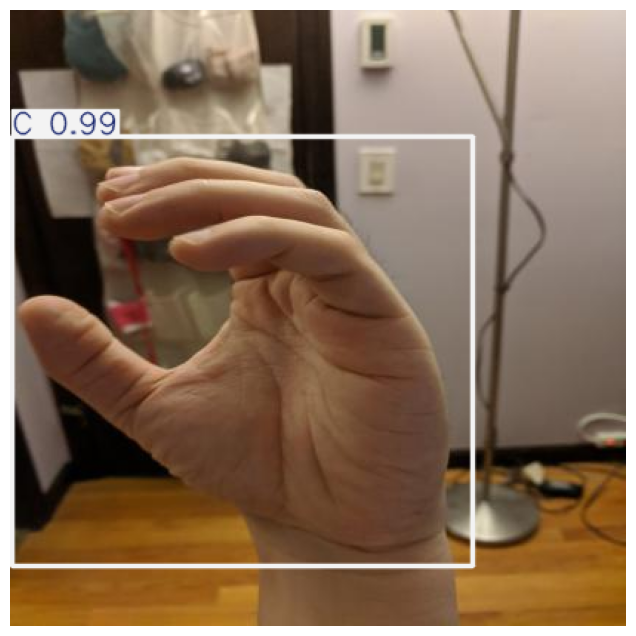

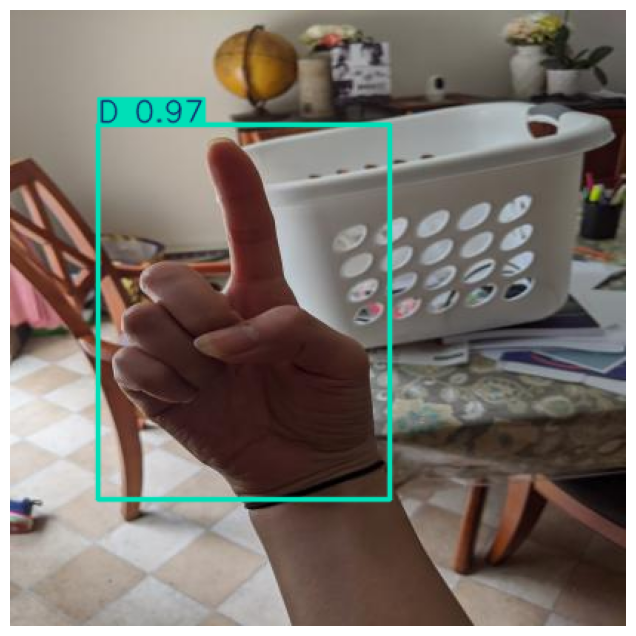

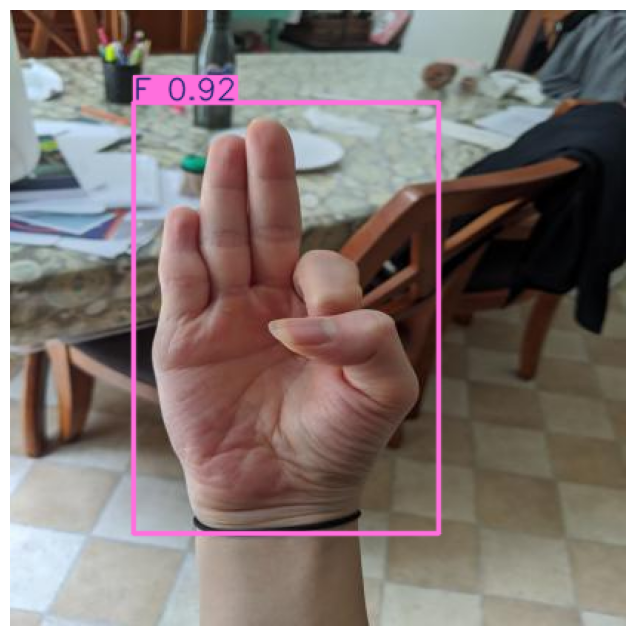

In [56]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load your trained model
model = YOLO('/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/asl_yolo9_training/yolov9n_asl2/weights/best.pt')

# Run predictions
results = model.predict(
    source='/Users/jonathanodonkor/Desktop/Work/4th Year/Semester 2/Intro to Ai/final_project/American Sign Language Letters.v1-v1.yolov9/test/images', 
    save=True
)

# Display the first few results
for r in results:
    # r.plot() gives you the annotated image (with bounding boxes)
    img = r.plot()

    # To convert BGR (OpenCV format) to RGB (matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    # This is to break after showing first 10 results
    if results.index(r) == 9:
        break